In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [2]:
data = pd.read_excel('leads_data.xlsx')

In [3]:
descriptive_stats = data.describe()
print(descriptive_stats)

              LeadId                       BornDate  \
count   30773.000000                          30773   
mean   219154.832646  2024-07-19 10:27:25.052480768   
min    186827.000000            2024-04-15 00:00:00   
25%    199807.000000            2024-06-03 00:00:00   
50%    216114.000000            2024-07-27 00:00:00   
75%    234720.000000            2024-09-02 00:00:00   
max    271777.000000            2024-10-15 00:00:00   
std     22639.899580                            NaN   

                        BornDateTime  CountOfClickEvents  \
count                          30773        30773.000000   
mean   2024-07-20 00:27:25.194553600           12.989894   
min              2024-04-15 00:54:45            0.000000   
25%              2024-06-03 21:22:08            6.000000   
50%              2024-07-27 15:08:34            9.000000   
75%              2024-09-02 13:25:49           14.000000   
max              2024-10-15 13:18:47         1452.000000   
std                     

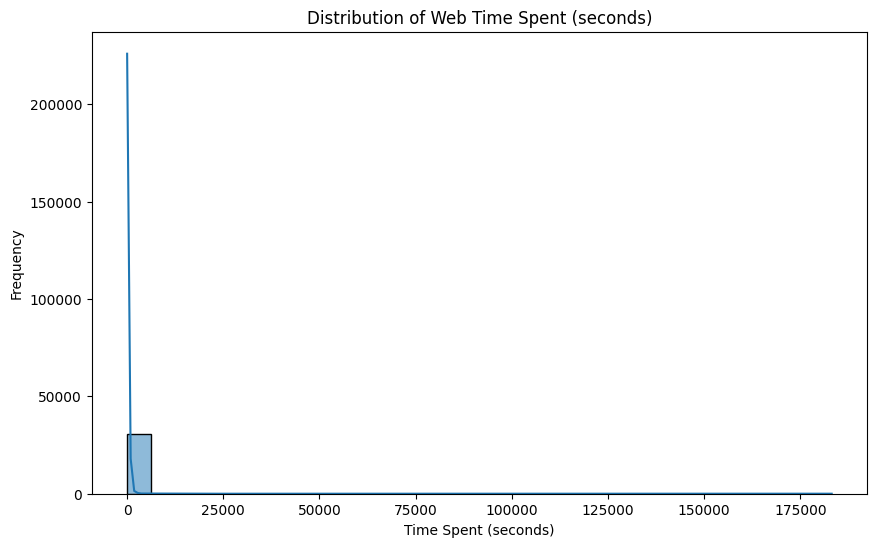

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data['WebTimeSpent (seconds)'], bins=30, kde=True)
plt.title('Distribution of Web Time Spent (seconds)')
plt.xlabel('Time Spent (seconds)')
plt.ylabel('Frequency')
plt.show()

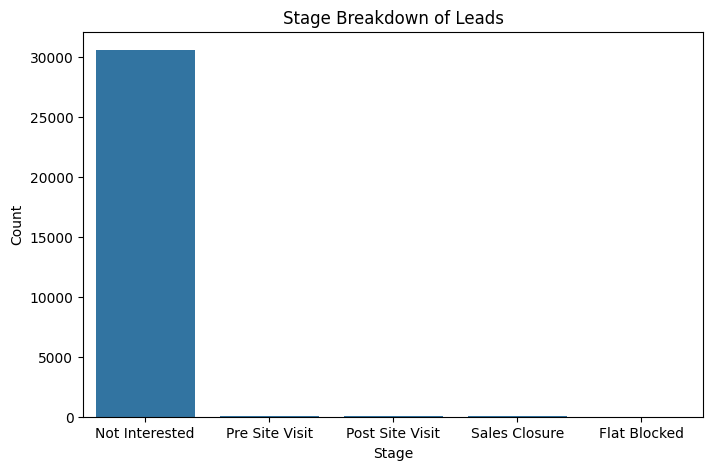

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Stage', order=data['Stage'].value_counts().index)
plt.title('Stage Breakdown of Leads')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.show()

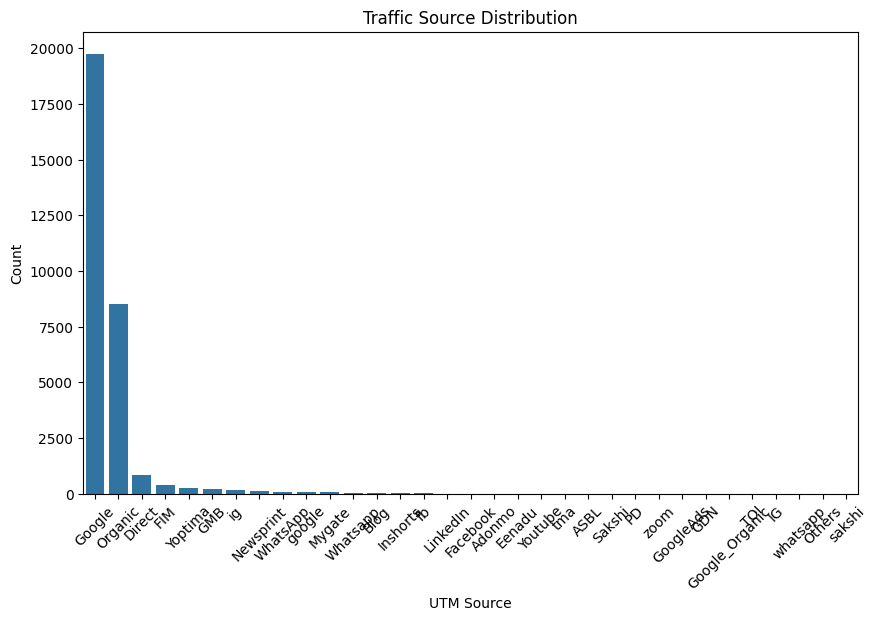

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='UTM-Source', order=data['UTM-Source'].value_counts().index)
plt.title('Traffic Source Distribution')
plt.xlabel('UTM Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

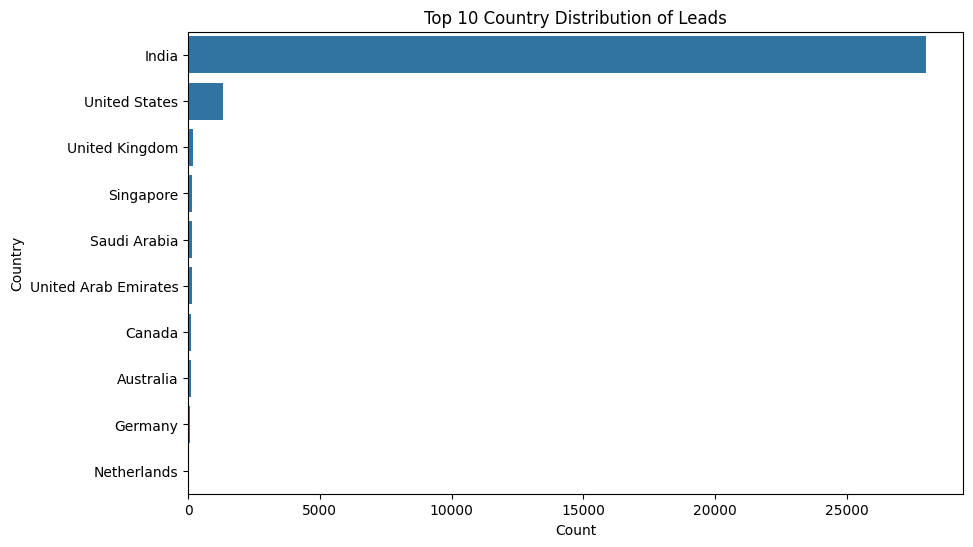

In [7]:
plt.figure(figsize=(10, 6))

# Filter the data to include only the top 5 countries by count
top_countries = data['Country'].value_counts().nlargest(10).index
sns.countplot(data=data[data['Country'].isin(top_countries)], y='Country', order=top_countries)

plt.title('Top 10 Country Distribution of Leads')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()


In [8]:
# Selecting relevant columns for scoring
features = data[['WebTimeSpent (seconds)', 'CountOfClickEvents', 
                       'InstanceNumber', 'PLAN_TimeSpent', 'PRICE_TimeSpent', 
                       'AMENITIES_TimeSpent', 'UTM-Source']]

# Normalizing continuous features
scaler = MinMaxScaler()
features[['WebTimeSpent (seconds)', 'CountOfClickEvents', 'InstanceNumber', 
          'PLAN_TimeSpent', 'PRICE_TimeSpent', 'AMENITIES_TimeSpent']] = scaler.fit_transform(
    features[['WebTimeSpent (seconds)', 'CountOfClickEvents', 'InstanceNumber', 
              'PLAN_TimeSpent', 'PRICE_TimeSpent', 'AMENITIES_TimeSpent']])

# Scoring UTM-Source Quality
utm_score_mapping = {'Google': 1.0, 'GMB': 0.9, 'GDN': 0.8, 'Other': 0.5}  # Example values
features['UTM-Source Quality'] = features['UTM-Source'].map(utm_score_mapping).fillna(0.5)

# Calculating the lead score
features['Lead Score'] = (
    0.3 * features['WebTimeSpent (seconds)'] +
    0.2 * features['CountOfClickEvents'] +
    0.2 * features['InstanceNumber'] +
    0.2 * (features['PLAN_TimeSpent'] + features['PRICE_TimeSpent'] + features['AMENITIES_TimeSpent']) +
    0.1 * features['UTM-Source Quality']
)

# Adding the Lead Score back to the original dataset
data['Lead Score'] = features['Lead Score']
print(data[['LeadId', 'Lead Score']].head())


   LeadId  Lead Score
0  198611    0.104898
1  193927    0.081046
2  230525    0.097535
3  208705    0.103283
4  253755    0.111996


C:\Users\bansa\AppData\Local\Temp\ipykernel_14540\2382781107.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[['WebTimeSpent (seconds)', 'CountOfClickEvents', 'InstanceNumber',
C:\Users\bansa\AppData\Local\Temp\ipykernel_14540\2382781107.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['UTM-Source Quality'] = features['UTM-Source'].map(utm_score_mapping).fillna(0.5)
C:\Users\bansa\AppData\Local\Temp\ipykernel_14540\2382781107.py:18: SettingWithCopyWarning: 
A value is trying to be s

In [9]:

# Ensure target variable is encoded (assuming 'Stage' is the target proxy for conversion)
data['Stage'] = LabelEncoder().fit_transform(data['Stage'])

# Define features and target
X = data[['WebTimeSpent (seconds)', 'CountOfClickEvents', 'InstanceNumber', 
                'PLAN_TimeSpent', 'PRICE_TimeSpent', 'AMENITIES_TimeSpent', 'UTM-Source']]
y = data['Stage']  # Replace with 'ConversionStatus' if available

# Convert categorical feature UTM-Source to numerical encoding
X = pd.get_dummies(X, columns=['UTM-Source'], drop_first=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

# Test the model and evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


Feature Importances:
                      Feature    Importance
0      WebTimeSpent (seconds)  3.644749e-01
4             PRICE_TimeSpent  2.584008e-01
1          CountOfClickEvents  1.214071e-01
3              PLAN_TimeSpent  1.184247e-01
2              InstanceNumber  9.569491e-02
5         AMENITIES_TimeSpent  1.108066e-02
14          UTM-Source_Google  5.639144e-03
22         UTM-Source_Organic  5.560867e-03
35             UTM-Source_tma  5.185796e-03
28        UTM-Source_Whatsapp  3.435217e-03
29         UTM-Source_Yoptima  2.644835e-03
21       UTM-Source_Newsprint  2.162744e-03
20          UTM-Source_Mygate  1.486920e-03
27        UTM-Source_WhatsApp  1.299035e-03
31              UTM-Source_fb  1.281436e-03
10             UTM-Source_FIM  5.983118e-04
13             UTM-Source_GMB  4.790668e-04
8           UTM-Source_Direct  3.040883e-04
7             UTM-Source_Blog  1.191696e-04
30         UTM-Source_Youtube  9.328389e-05
33              UTM-Source_ig  8.546812e-05
37         

C:\Users\bansa\OneDrive\Desktop\intern\asbl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bansa\OneDrive\Desktop\intern\asbl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bansa\OneDrive\Desktop\intern\asbl\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

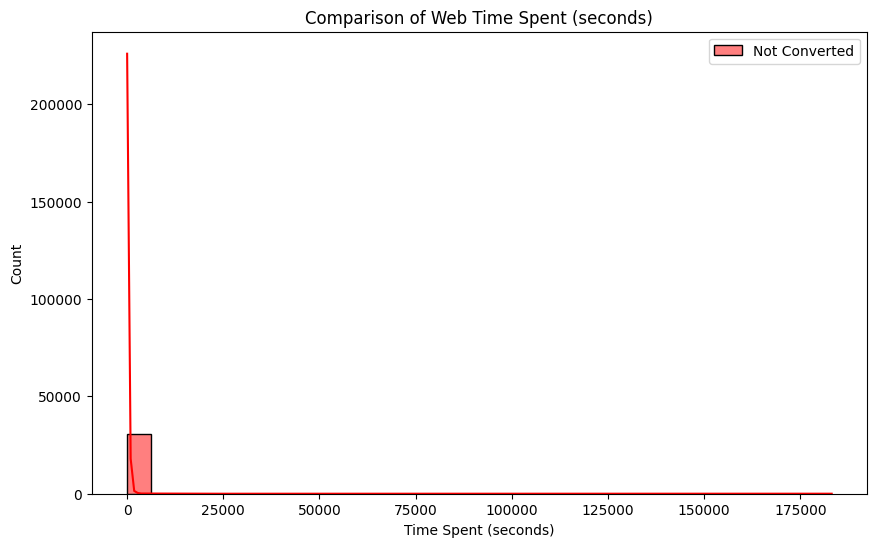

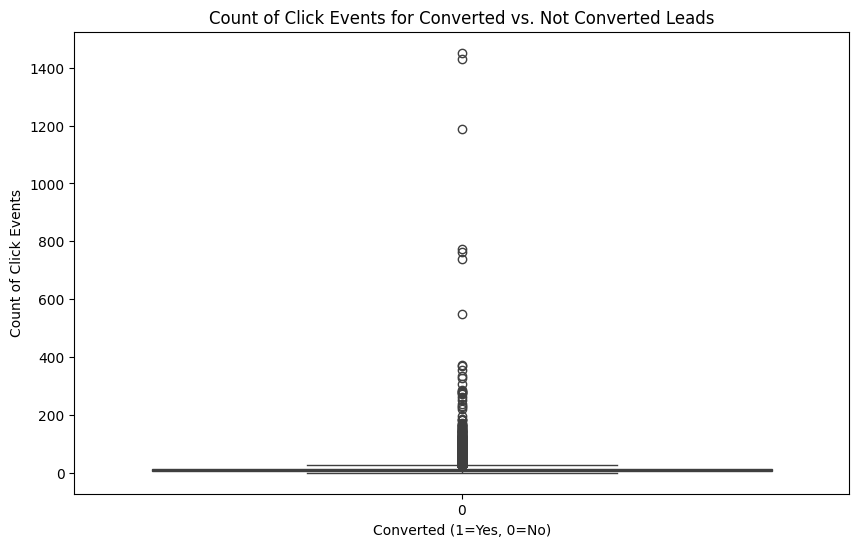

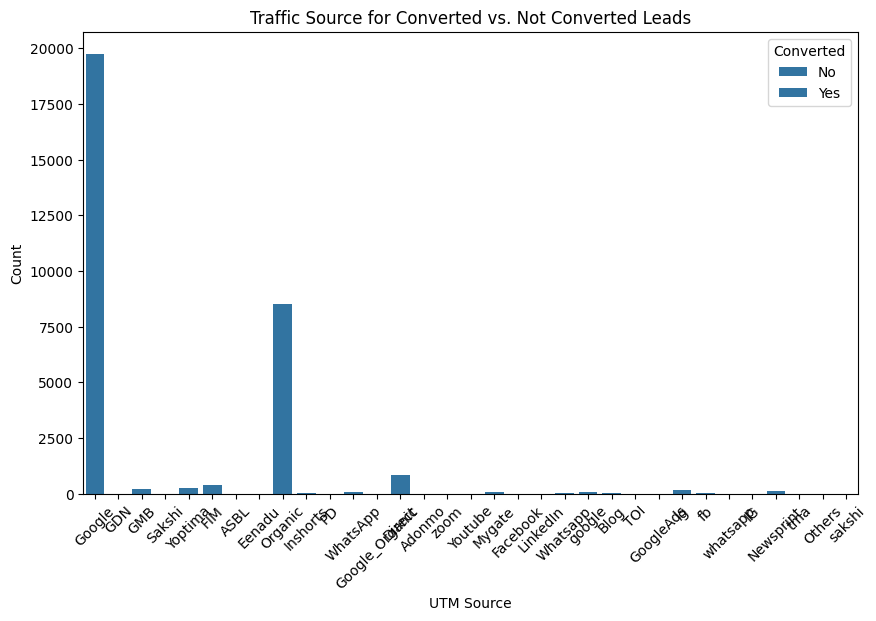

Converted Leads Summary:
       LeadId BornDate BornDateTime  Stage  CountOfClickEvents  \
count     0.0        0            0    0.0                 0.0   
mean      NaN      NaT          NaT    NaN                 NaN   
min       NaN      NaT          NaT    NaN                 NaN   
25%       NaN      NaT          NaT    NaN                 NaN   
50%       NaN      NaT          NaT    NaN                 NaN   
75%       NaN      NaT          NaT    NaN                 NaN   
max       NaN      NaT          NaT    NaN                 NaN   
std       NaN      NaN          NaN    NaN                 NaN   

       WebTimeSpent (seconds)  InstanceNumber  HOME_TimeSpent  \
count                     0.0             0.0             0.0   
mean                      NaN             NaN             NaN   
min                       NaN             NaN             NaN   
25%                       NaN             NaN             NaN   
50%                       NaN             NaN          

In [10]:
# Check if 'Stage' column has values that can indicate conversion
# Adjust these values based on your dataset's specific labels for successful conversion
conversion_stages = ['Closed', 'Converted']  # Update this list if needed

# Create a new 'Converted' column based on 'Stage'
data['Converted'] = data['Stage'].apply(lambda x: 1 if x in conversion_stages else 0)

# Separate the data into converted and non-converted groups
converted_leads = data[data['Converted'] == 1]
non_converted_leads = data[data['Converted'] == 0]

# Continue with the analysis and visualizations

# Compare Web Time Spent
plt.figure(figsize=(10, 6))
sns.histplot(converted_leads['WebTimeSpent (seconds)'], color="green", label="Converted", kde=True, bins=30)
sns.histplot(non_converted_leads['WebTimeSpent (seconds)'], color="red", label="Not Converted", kde=True, bins=30)
plt.title('Comparison of Web Time Spent (seconds)')
plt.xlabel('Time Spent (seconds)')
plt.legend()
plt.show()

# Compare Count of Click Events
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Converted', y='CountOfClickEvents')
plt.title('Count of Click Events for Converted vs. Not Converted Leads')
plt.xlabel('Converted (1=Yes, 0=No)')
plt.ylabel('Count of Click Events')
plt.show()

# Compare UTM Source
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='UTM-Source', hue='Converted')
plt.title('Traffic Source for Converted vs. Not Converted Leads')
plt.xlabel('UTM Source')
plt.ylabel('Count')
plt.legend(title="Converted", labels=["No", "Yes"])
plt.xticks(rotation=45)
plt.show()

# Summary statistics to compare
converted_summary = converted_leads.describe()
non_converted_summary = non_converted_leads.describe()

print("Converted Leads Summary:")
print(converted_summary)
print("\nNon-Converted Leads Summary:")
print(non_converted_summary)